In [ ]:
from experta import Rule, NOT, AND,MATCH
from experta import Fact, W
from experta.engine import KnowledgeEngine

class Person(Fact):
    pass

class ConflictResolver(Fact):
    pass

executions = []
class Person_KE(KnowledgeEngine):
    @Rule(NOT(ConflictResolver(resolved=True)),AND(Person(age=MATCH.age),Person(age=~MATCH.age)))
    def same_name(self, age):
        executions.append(age)
        
ke_ = Person_KE()
ke_.reset()
print(ke_.declare(Person(name="name1", age=18)))
ke_.declare(Person(name='name2', age=19))
ke_.declare(ConflictResolver(resolved=True))
ke_.run()
print(executions)
assert executions == []

In [ ]:
# pip install experta

In [ ]:
from experta import KnowledgeEngine, Rule,Fact
class KE(KnowledgeEngine):
    @Rule(salience = 985)
    def runfirst(self):
        self.declare(Fact('A'))
        
    @Rule(salience = 990)
    def runsecond(self):
        self.declare(Fact('B'))
        self.halt()
    
        
    @Rule(salience = 995)
    def runthird(self):
        self.declare(Fact('C'))
        self.halt()
        
ke = KE()
ke.reset()
ke.run()
ke.facts

In [ ]:
ke.run()
ke.facts

In [ ]:
ke.run()
ke.facts

In [ ]:
from experta import KnowledgeEngine, Fact
ke = KnowledgeEngine()
f1 = ke.declare(Fact())
print(f1)
assert len(ke.facts) == 1
ke.facts


In [ ]:
f3=ke.modify(f1, _0='test_pos', key='test_key')
# # assert f1 != f2
# # print(f2)
# assert len(ke.facts) == 1
# assert f2.__factid__ in ke.facts
# assert f2[0] == 'test_pos'
# assert f2['key'] == 'test_key'
ke.facts

In [ ]:
f3.__factid__

In [ ]:
from experta import KnowledgeEngine, Fact
ke = KnowledgeEngine()
f1 = ke.declare(Fact(color='red'))
ke.facts

In [ ]:
assert len(ke.facts) == 1
f2 = ke.duplicate(f1, color='yellow', blink=True)
assert len(ke.facts) == 2
assert f2 is not f1
assert f2['color'] == 'yellow'
assert f2['blink']
ke.facts

In [ ]:
for fi in ke.facts:
    print(fi)

In [ ]:
def test_reset_kwargs_are_passed_to_deffacts_kwargs():
    from experta import KnowledgeEngine, DefFacts, Fact
    passed = False
    class KE(KnowledgeEngine):
        @DefFacts()
        def init(self, **kwargs):
            passed = kwargs
            yield Fact()
    ke = KE()
    ke.reset(arg=True)
    assert passed == {"arg": True}

# Writing the PC Repair Assistant

Collect knowledge using flowcharts

Translate flowcharts into rules

# Using flowcharts in knowledge engineering

Diagnostic knowledge can be represented fairly well using flowcharts. A lot of information can be compactly represented by a few symbols, 

A simple flowchart representing a trivial diagnostic process. The hypothesis “The car won’t run because it has no fuel” is implicit in the diagram.

you’re drawing flowcharts during an interview with a domain expert

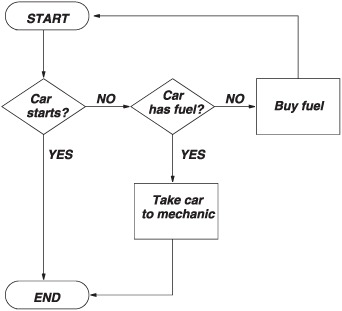

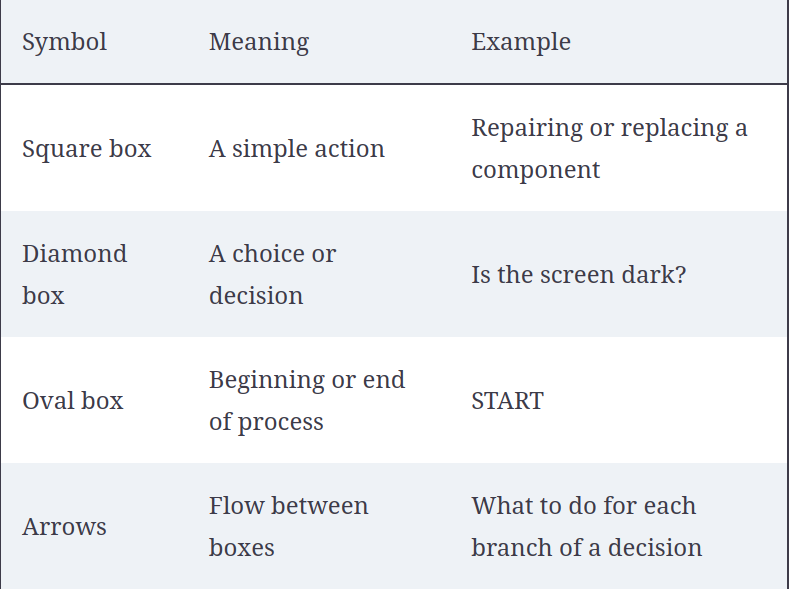

# From flowcharts to rules
Translating flowcharts into rules is fairly straightforward. In general, there is one rule for every action box, and there are additional rules for some of the oval boxes. A possible set of rules for the flowchart includes three rules: one each for the action boxes in the flowchart and one for the END oval. Note that each rule corresponds to a specific hypothesis about what might be wrong with the car

Three rules that capture the logic from flowchart

In [ ]:
from experta import *
@Rule(Fact(car_starts = L('no'),car_has_fuel=L("no")))
def no_fuel(self):
    #"This rule corresponds to the 'buy fuel' box"
    self.declare(Fact(buy="fuel"))
    
@Rule(Fact(car_starts = L('no'),car_has_fuel=L("yes")))
def faulty_engine(self):
    #"This rule is for the 'take car to mechanic' box"
    self.declare(Fact(take_car="mechanic"))
    

@Rule(Fact(car_starts = L('yes')))
def  car_is_ok(self):
         #"This rule corresponds to the 'END' oval"
         self.declare(Fact(car="ok"))


in diagnose problems with computers, so you should be able to represent the knowledge you gather in a series of flowcharts. If you were gathering the knowledge by interviewing a computer repair technician, you could start by asking her to list some of the most common computer problems she deals with. 

For each of these problems, you’d develop a flowchart around the hypothesis that this particular problem was affecting the broken computer. Each of these flowcharts would show the series of tests the technician would perform to attempt to verify or disprove the hypothesis.

It should be easy to imagine how the interview would be conducted. For each flowchart, you’d ask, “What would you do first to diagnose this problem, and what are the possible outcomes?”

# The problem domain
“problems with desktop computers” is a very broad domain, and you need to narrow it down a lot before you can get started. First, let’s specialize desktop computers to x86-based desktop computers. We won’t consider Macintosh machines or any other architectures—just those systems that are commonly referred to as PCs. You can formalize this specialization in a rule

In [ ]:
class Answer(Fact):
    pass

class question(Fact):
    pass
class need_answer(Fact):
    pass

@Rule(Answer(ident = L('hardware'),text=~L("x86")))
def false_architecture(self):
        self.recommend_action("consult a human expert")
        self.halt()

To further restrict the domain, the system you’re writing diagnoses only hardware problems, not software issues. Broken power supplies, loose video cards, and faulty memory chips  let’s restrict the domain to include only computers that won’t boot. This leaves out many hardware problems: You won’t try to diagnose nonfunctional network cards, jammed CD-ROM drives, and other broken components not directly involved in booting the machine.

Writing the first rules

 If the computer makes no sound at all, the presumed hypotheses are The computer isn’t getting any electricity and The power supply is faulty.
 
 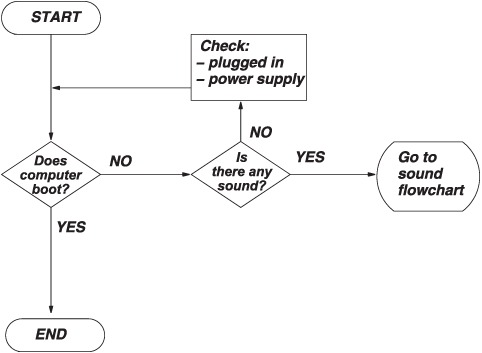

In [ ]:
# Rules to diagnose a computer that makes no sound

@Rule(Answer(ident = L('sound'),text=L("no")),
          Answer(ident = L('plugged-in'),text=L("no")))
def not_plugged_in(self):
        self.recommend_action("plug in the computer")
        self.halt()
        
@Rule(Answer(ident = L('sound'),text=L("no")),
          Answer(ident = L('plugged-in'),text=L("yes")))
def power_supply_broken(self):
        self.recommend_action("repair or replace power supply")
        self.halt()

The action Check power supply should ideally expand to a whole flowchart of its own, explaining the steps involved in diagnosing power-supply problems.

 The cycle of rules that fire to get answers from the user in this application. The rule power-supply-broken needs an answer fact before it matches. we will try to detects this requirement and asserts a needed answer fact. 
    
There are rule detects needed fact and asserts an ask fact in response. Finally, the ask-question-by-id rule fires in response to the ask fact and supplies the answer fact needed by power-supply-broken or any other rule neeeded it.

# Checking the answers


this application needs to be able to validate three different kinds of answers:

    Multiple choice (multi)— One of a set of allowed answers. Yes or no questions .
    Numeric— Any integer value.
    Text— Any arbitrary text.

 The ask-question-by-id rule needs to match this multifield and pass it along to an extended version of the ask-user function. ask-user, in turn, needs to pass the multifield to an enhanced is-of-type function, which can validate questions of type multi, numeric, and text. 

In [ ]:
@Rule(question(ident = MATCH.id,text=MATCH.text,valid=MATCH.valid,Type=MATCH.Type),
          NOT(Answer(ident = MATCH.id)),
          AS.ask << Fact(ask = MATCH.id)
         )
def ask_question_by_id(self,ask,id,text,valid,Type):
        #"Ask a question and assert the answer""
        self.retract(ask)
        answer=self.ask_user(text,Type,valid)
        self.declare(Answer(ident = id,text=answer))

A simple flowchart for diagnosing some hardware problems in computers that make sound but don’t boot. The ERROR state is supposed to be impossible to reach.
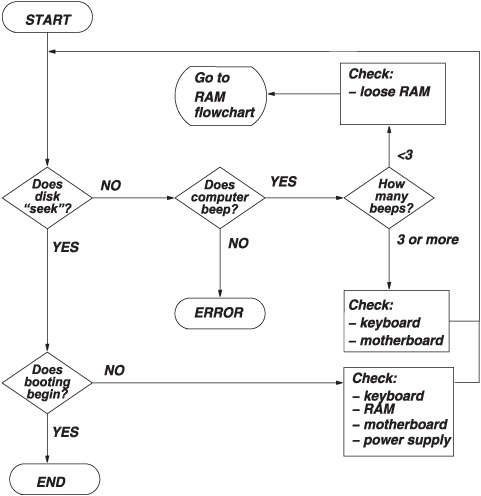

# Rules about sound
The trigger to enter this flowchart in the first place occurs when the user answers “no” to the sound question; therefore all the rules begin with the pattern (answer (ident sound) (text no)). Any decisions made before this point are irrelevant to these rules. The first decision in the sound flowchart is whether the disk makes “seeking” sounds;
 the Check keyboard and motherboard action is reached by passing through the seek, does-beep, and how-many-beeps decisions, so it looks like this:

In [ ]:
@Rule(Answer(ident="sound",text="yes"),
          Answer(ident="seek",text="no"),
          Answer(ident="does-beep",text="yes"),
          Answer(ident="how-many-beeps",text=MATCH.T),#GE(3)
         TEST(lambda t: int(t)>=3)
         )
def motherboard_or_keyboard(self,ask,id,text,valid,Type):
        #"Ask a question and assert the answer""
        self.recommend_action("check keyboard and motherboard")
        self.halt()

In [ ]:
#The check-ram rule is similar, but with a twist. Besides recommending an action, this rule asserts a check fact, and does not call (halt):
@Rule(Answer(ident="sound",text="yes"),
          Answer(ident="seek",text="no"),
          Answer(ident="does-beep",text="yes"),
          Answer(ident="how-many-beeps",text=MATCH.T),
         TEST(lambda t: int(t)<3)
         )
def check_ram(self):
        self.declare(Fact(check = "loose-ram"))
        self.recommend_action("check for loose RAM, then continue")

The diagnostic flowchart for computers that beep fewer than three times and then don’t boot
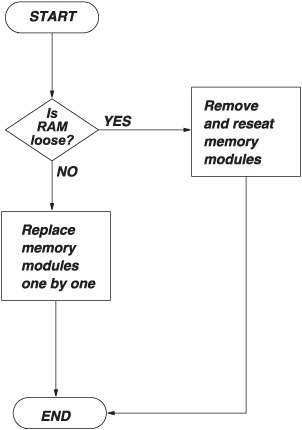

In [ ]:
from experta import *
class DiagnosticExpert(KnowledgeEngine):
    
    def recommend_action(self,action):
        #"Give final instructions to the user"
        print("I recommend that you "+action+"\n")
        
    @DefFacts()
    def init(self, **kwargs):
        yield question(ident ="hardware",
                       Type="multi",
                       valid=["x86","Macintosh","other"],
                       text="What kind of hardware is it?")
        
        yield question(ident ="sound",
                       Type="multi",
                       valid=["yes" ,"no"],
                       text="Does the computer make any sound?")
        
        yield question(ident ="plugged-in",
                       Type="multi",
                       valid=["yes" ,"no"],
                       text="Is the computer plugged in?")
        
        yield question(ident ="seek",
                       Type="multi",
                       valid=["yes" ,"no"],
                       text="Does the disk make \"seeking\" sounds?")
        
        yield question(ident ="does-beep",
                       Type="multi",
                       valid=["yes" ,"no"],
                       text="Does the computer beep?")
        
        yield question(ident ="how-many-beeps",
                       Type="number",
                       valid="0",
                       text="How many times does it beep")
        
        yield question(ident ="loose-ram",
                       Type="multi",
                       valid=["yes" ,"no"],
                       text="Are any of the memory modules loose?p")
        
        yield question(ident ="boot-begins",
                       Type="multi",
                       valid=["yes" ,"no"],
                       text="Does the computer begin to boot?")
        
    
    @Rule(NOT(Answer(ident = L('hardware'))),
          NOT(Fact(ask = L('hardware'))))
    def supply_answer_hw(self):
        self.declare(Fact(ask ="hardware"))
   
        
    @Rule(Answer(ident = L('hardware'),text=~L("x86")))
    def false_architecture(self):
        self.recommend_action("consult a human expert")
        self.halt()
        
        
    @Rule(Answer(ident = L('hardware'),text=L("x86")))
    def right_architecture(self):
        self.declare(Fact(ask ="seek"))
    
    @Rule(Answer(ident = L('sound'),text=L("no")),
          Answer(ident = L('plugged-in'),text=L("no")))
    def not_plugged_in(self):
        self.recommend_action("plug in the computer")
        self.halt()
        
    @Rule(Answer(ident = L('sound'),text=L("no")),
          Answer(ident = L('plugged-in'),text=L("yes")))
    def power_supply_broken(self):
        self.recommend_action("repair or replace power supply")
        self.halt()
    
    @Rule(Answer(ident = L('loose-ram'),text=L("no")))
    def looseRam(self):
        self.recommend_action("repleace memory moduleone by one ")
        self.halt()
        
    @Rule(Answer(ident = L('loose-ram'),text=L("yes")))
    def looseRam(self):
        self.recommend_action("remove and reset memory modules")
        self.halt()
     
    
    @Rule(Answer(ident="sound"),
          NOT(Answer(ident ="plugged-in")))
    def supply_answer_plugged_in(self):
        self.declare(Fact(ask ="plugged-in"))
    
    @Rule(Answer(ident="seek",text="yes"),
          NOT(Answer(ident ="boot-begins")))
    def supply_answer_boot_begin(self):
        self.declare(Fact(ask ="boot-begins"))
    
    @Rule(Answer(ident="seek",text="no"),
          NOT(Answer(ident ="does-beep")))
    def supply_answer_does_beep(self):
        self.declare(Fact(ask ="does-beep"))
        
    @Rule(Answer(ident="boot-begins",text="yes"),
          NOT(Answer(ident ="sound")))
    def supply_answer_make_sound(self):
        self.declare(Fact(ask ="sound"))
        
        
    def ask_user(self,question,Type,valid=None):
        # "Ask a question, and return the answer"
        answer=""
        while not(self.is_of_type(answer,Type,valid)):
            print(question)
            if Type=="multi":
                print("Valid answers are ")
                for item in valid:
                    print(str(item)+" ")
                print("\n")
            answer=input()
        return answer
    
    
    def is_a_number(self,answer):
        try:
            int(answer)
            return True
        except:
            return False
    def is_of_type(self,answer,Type,valid):
        #"Check that the answer has the right form"
        if Type=="multi":
            for item in valid:
                if answer==item:
                    return True
            return False
        if Type=="number":
            return is_a_number(answer)
        return len(answer)>0
        
    @Rule(question(ident = MATCH.id,text=MATCH.text,valid=MATCH.valid,Type=MATCH.Type),
          NOT(Answer(ident = MATCH.id)),
          AS.ask << Fact(ask = MATCH.id)
         )
    def ask_question_by_id(self,ask,id,text,valid,Type):
        #"Ask a question and assert the answer""
        self.retract(ask)
        answer=self.ask_user(text,Type,valid)
        self.declare(Answer(ident = id,text=answer))
        
    @Rule(Answer(ident="sound",text="yes"),
          Answer(ident="seek",text="no"),
          Answer(ident="does-beep",text="yes"),
          Answer(ident="how-many-beeps",text=MATCH.T),#GE(3)
         TEST(lambda t: int(t)>=3)
         )
    def motherboard_or_keyboard(self,ask,id,text,valid,Type):
        #"Ask a question and assert the answer""
        self.recommend_action("check keyboard and motherboard")
        self.halt()
        
    @Rule(Answer(ident="sound",text="yes"),
          Answer(ident="seek",text="no"),
          Answer(ident="does-beep",text="yes"),
          Answer(ident="how-many-beeps",text=MATCH.T),
         TEST(lambda t: int(t)<3)
         )
    
#     @Rule(Answer(ident="loose-ram",text="no")
#     def checkLoosRamNo(self):
#         self.recommend_action("repleace memory moduleone by one ")
#         self.halt())
#     @Rule(Answer(ident="loose-ram",text="yes"),
#     def checkLoosRamYes(self):
#           self.recommend_action("remove and reset memory modules")
#          )
#     def check_ram(self):
#         self.declare(Fact(check = "loose-ram"))
#         self.recommend_action("check for loose RAM, then continue")
    
    @Rule(Fact(check='loose-ram'))
    def askQues(self):
        self.declare(Fact(ask="loose-ram"))
#     @Rule(Answer(ident="loose-ram",text="yes"),
#     def checkLoosRamYes(self):
#           self.recommend_action("remove and reset memory modules"))
#     @Rule(Answer(ident="loose-ram",text="no"),
#     def checkLoosRamNo(self):
#         self.recommend_action("repleace memory moduleone by one ")
#         self.halt())
        
    @Rule(Answer(ident="sound",text="yes"),
          Answer(ident="seek",text="no"),
          Answer(ident="does-beep",text="no")
         )
    def unknown_sound(self):
        self.recommend_action("consult a human expert")
        self.halt()
        
        
    @Rule(Answer(ident="sound",text="yes"),
          Answer(ident="seek",text="yes"),
          Answer(ident="boot-begins",text="no")
         )
    def no_boot_start(self):
        self.recommend_action("check keyboard, RAM, motherboard, and power supply")
        self.halt()
        
        
    @Rule(Answer(ident="sound",text="yes"),
          Answer(ident="seek",text="yes"),
          Answer(ident="boot-begins",text="yes")
         )
    def boot_start(self):
        self.recommend_action("consult a software expert")
        self.halt()    

In [ ]:
engine = DiagnosticExpert()
engine.reset()
engine.run()

In [ ]:
engine.run()

In [ ]:
from random import choice
from experta import *

class Answer(Fact):
    pass

class question(Fact):
    pass
class need_answer(Fact):
    pass

def false_architecture(self):
        self.recommend_action("consult a human expert")
        self.halt()
@Rule(question(ident = MATCH.id,text=MATCH.text,valid=MATCH.valid,Type=MATCH.Type),
          NOT(Answer(ident = MATCH.id)),
          AS.ask << Fact(ask = MATCH.id)
         )
        
def ask_question_by_id(self,ask,id,text,valid,Type):
        #"Ask a question and assert the answer""
        self.retract(ask)
        answer=self.ask_user(text,Type,valid)
        self.declare(Answer(ident = id,text=answer))
class DiagnosticExpert(KnowledgeEngine):
    def recommend_action(self,action):
        print("I recommend that you "+action+"@Rule(NOT(Answer(ident = L('diseases')))) ,  NOT(Fact(ask = L('diseases'))))")
    def supply_answer_hw(self):
        self.declare(Fact(ask ="diseases"))

        
    @Rule(Answer(ident = L('diseases'),text=~L("canser")))
    def false_architecture(self):
        self.recommend_action("consult a human expert")
        self.halt()

        
    @DefFacts()
    def init(self, **kwargs):
        yield question(ident ="diseases",
                       Type="multi",
                       valid=["canser","Hypertension","diet"],
                       text="What kind of hardware is it?")
        
        
        yield question(ident ="loose-ram",
                       Type="multi",
                       valid=["yes" ,"no"],
                       text="Are any of the memory modules loose?p")
        
@Rule(NOT(Answer(ident = L('diseases'))),
          NOT(Fact(ask = L('diseases'))))
def supply_answer_how(self):
    self.declare(Fact(ask ="diseases"))
        
@Rule(Answer(ident = L('diseases'),text=~L("canser")))
def false_architecture(self):
    self.recommend_action("consult a human expert")
    self.halt()
        

class Light(Fact):
    """Info about the traffic light."""
    pass

    @Rule(Light(color='green'))
    def green_light(self):
        print("Walk")

    @Rule(Light(color='red'))
    def red_light(self):
        print("Don't walk")
    
        
    
    @Rule(Fact(check=''))
    def askQues(self):
        self.declare(Fact(ask="loose-ram"))
        
    
    @Rule(AS.light << Light(color=L('yellow') | L('blinking-yellow')))
    def cautious(self, light):
        print("Be cautious because light is", light["color"])

        
    def ask_user(self,question,Type,valid=None):
        # "Ask a question, and return the answer"
        answer=""
        while not(self.is_of_type(answer,Type,valid)):
            print(question)
            if Type=="multi":
                print("Valid answers are ")
                for item in valid:
                    print(str(item)+" ")
                print("\n")
            answer=input()
        return answer
    @Rule(question(ident = MATCH.id,text=MATCH.text,valid=MATCH.valid,Type=MATCH.Type),
          NOT(Answer(ident = MATCH.id)),
          AS.ask << Fact(ask = MATCH.id)
         )
    def ask_question_by_id(self,ask,id,text,valid,Type):
        #"Ask a question and assert the answer""
        self.retract(ask)
        answer=self.ask_user(text,Type,valid)
        self.declare(Answer(ident = id,text=answer))

    def boot_start(self):
        self.recommend_action("consult a software expert")
        self.halt()    
print("Some")

In [ ]:
engine = DiagnosticExpert()
engine.reset()
engine.run()